# Full-batch FashionMNIST
We shall train a tiny (under 10k params) FashionMNIST convolutional neural network using full-batch training.

### 1. Introduction

Full-batch training has no stochasticity, and with tiny models we can use fast quasi-newton methods.

If you have under ~5,000 parameters, as long as optimization is running on a GPU for fast matmuls, full-matrix quasi-newton methods (such as BFGS) are recommended, as they typically are both faster to compute and have faster convergence compared to limited-memory versions.

BFGS with backtracking line search is fast, robust, requires no tuning and should generally be the first algorithm to try. If you want to squeeze more, sometimes other algorithms may outperform BFGS, here are some you could try:

```py
# BFGS with backtracking line search.
[tz.m.BFGS(), tz.m.Backtracking()]

# SR1 with Levenberg-Marquardt trust region. SR1 hessian approximation is prone to becoming defective
# an easy fix is to reset it whenever no progress is made for multiple consecutive steps.
# In torchzero ResetOnStuck does just that
[LevenbergMarquardt(ResetOnStuck(SR1(inverse=False)))]

# In some cases Shor's r-algorithm outperforms quasi-newton methods by a lot,
# espeically with weirder objectives and losses
[ResetOnStuck(ShorR()), StrongWolfe(a_init="first-order")]
```

With over 5,000 parameters limited-memory variants typically take less compute to converge to the same loss. Here you should generally go for L-BFGS with backtracking line search. Torchzero also implements L-SR1, and both support TrustCG trust region instead of a line search.

If you are looking for something that requires less memory and compute, use conjugate gradient methods (I haven't tested them extensively yet).

Finally, in many cases the SOAP optimizer outerperforms quasi-newton methods even on full-batch training. The only downside is that it requires tuning the learning rate. If SOAP is too expensive, Adam is good enough in most cases.



This notebook was ran on a GTX 1650 with 4 GB VRAM.

### 2. Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchzero as tz
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import random
from torchvision.datasets import FashionMNIST

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### 3. Load the dataset

FashionMNIST is like MNIST but a bit harder. Each sample is a single channel 28x28 image and an integer label from 0 to 9.

I stacked the entire dataset into a tensor and move it to GPU for efficiency.

In [2]:
def to_tensors(ds):
    inputs = []
    targets = []
    for input, target in ds:
        inputs.append(torch.tensor(np.array(input), dtype=torch.float32))
        targets.append(torch.tensor(np.array(target), dtype=torch.long))

    # znormalize
    inputs = torch.stack(inputs)
    inputs = (inputs - inputs.mean() / inputs.std())

    return inputs.cuda(), torch.stack(targets).cuda()

fm_train = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=True, download=True)
fm_test = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=False, download=True)

train_X, train_y = to_tensors(fm_train)
test_X, test_y = to_tensors(fm_test)

train_X.unsqueeze_(1)
test_X.unsqueeze_(1)

# train_y = F.one_hot(train_y).float()
# test_y = F.one_hot(test_y).float()

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

### 4. Define the model

When defining the model, keep in mind that quasi-newton methods usually work better when the objective function is smooth, and in neural networks activation function and max-pooling are the two main sources of non-smoothness. I found that ELU activation tends to work best. This is not a hard rule - quasi-newton methods can still work well with non-smooth functions and even ReLUs.

We will use a 4-layer convolutional net with 9.6k parameters. A larger model can be trained in full-batch mode using gradient accumulation if  VRAM is not large enough, however it can be slower.

In [3]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, 2)
        self.c2 = nn.Conv2d(16, 24, 3, 2)
        self.c3 = nn.Conv2d(24, 32, 2, 2)
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(32*9, 10))

    def forward(self, x):
        x = F.elu(self.c1(x), inplace=True)
        x = F.elu(self.c2(x), inplace=True)
        x = F.elu(self.c3(x), inplace=True)
        return self.head(x)

print(TinyConvNet()(torch.randn(1,1,28,28)).shape)
count_params(TinyConvNet())

torch.Size([1, 10])


9634

### 5. Define the training function

In [4]:
def run(opt_fn, num_steps: int):
    model = TinyConvNet().cuda()

    opt = opt_fn(model.parameters())

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []

    def closure(backward=True):
        y_hat = model(train_X)
        loss = F.cross_entropy(y_hat, train_y)
        if backward:
            opt.zero_grad()
            loss.backward()

        # test loss
        # this will be logged on each function evaluation, maybe not the most efficient way
        # but that way number of function evaluations is plotted on the x axis.
        # I think that's more fair when using algorithms that do a lot of evaluations per step.
        # and that way minimizers like ScipyMinimize or NLOptWrapper work too.
        with torch.no_grad():
            train_accuracy = (y_hat.argmax(-1) == train_y).float().mean()
            y_hat_test = model(test_X)
            test_loss = F.cross_entropy(y_hat_test, test_y)
            test_accuracy = (y_hat_test.argmax(-1) == test_y).float().mean()

            # log
            train_losses.append(loss.item())
            test_losses.append(test_loss.item())
            train_acc.append(train_accuracy.item())
            test_acc.append(test_accuracy.item())

        return loss

    pbar = tqdm.trange(num_steps)
    for step in pbar:
        loss = opt.step(closure)
        pbar.set_description(str(loss))

    print(f"{max(test_acc) = }")
    print(f'{min(test_losses) = }')

    plt.plot(train_acc, label='train')
    plt.plot(test_acc, label='test')
    plt.xlabel('number of function evaluations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    return model, train_losses, test_losses, train_acc, test_acc

### 6. Run L-BFGS
After some experiments I found that L-BFGS with decoupled relative weight decay and a backtracking line search works best.

In 6 minutes we achieve test 0.902 accuracy, which is better than 0.897 achieved with sklearn in over an hour of traning time (http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/#). Of course we have the advantage of using convolutions, which none of the sklearn fitters do.

  0%|          | 0/1000 [00:00<?, ?it/s]

tensor(0.0952, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 1000/1000 [06:09<00:00,  2.71it/s]

max(test_acc) = 0.9021999835968018
min(test_losses) = 0.28926363587379456


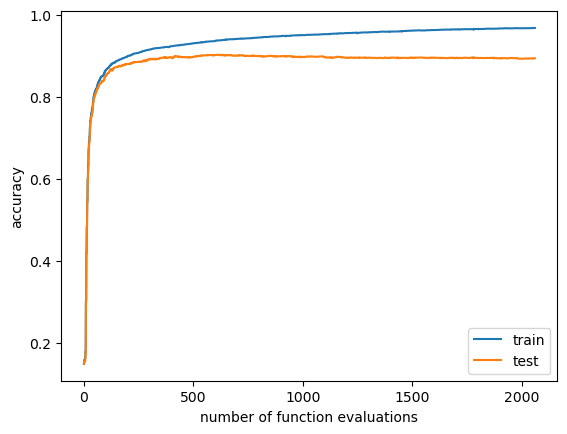

In [ ]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.LBFGS(100),
        tz.m.RelativeWeightDecay(0.2),
        tz.m.Backtracking()
    ),
    num_steps=1000,
)

### 7. Testing other optimizers

Let's also try AdamW. I picked 2000 steps to take roughtly the same time as 1000 L-BFGS steps, mainly due to each L-BFGS step performing multiple evaluations due to a line search. Now Adam requires tuning and maybe with appropriate hyperparameters it converges faster, but tuning requires a lot of time. For this I only tuned learning rate and weight decay.

tensor(0.1522, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 2000/2000 [07:04<00:00,  4.71it/s]

max(test_acc) = 0.8910999894142151
min(test_losses) = 0.3310447335243225


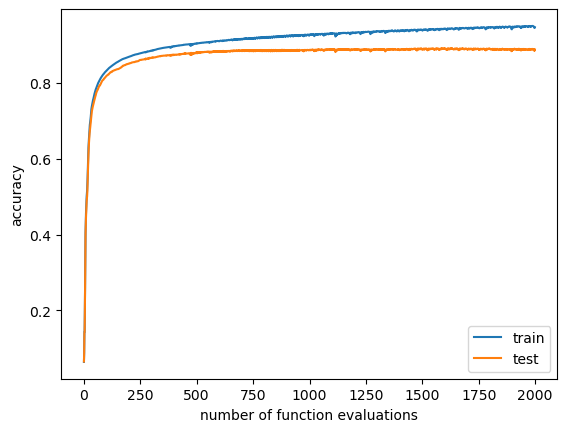

In [ ]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.Adam(),
        tz.m.RelativeWeightDecay(0.2),
        tz.m.LR(1e-3)
    ),
    num_steps=2000,
)

SOAP converges to a much better train loss than even L-BFGS, however it overfits strongly.

tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>): 100%|██████████| 2000/2000 [07:29<00:00,  4.45it/s]

max(test_acc) = 0.8888999819755554
min(test_losses) = 0.3315754532814026


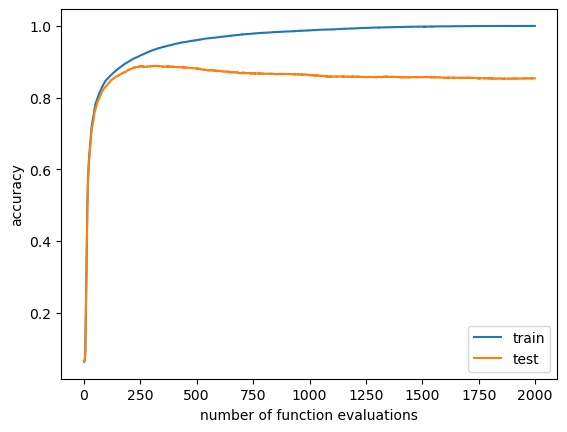

In [ ]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SOAP(),
        tz.m.RelativeWeightDecay(0.2),
        tz.m.LR(1e-3)
    ),
    num_steps=2000,
)